### Modeling

The data has been aggregated and cleaned. Here I will produce and compare the performance of several models before selecting one and tuning it for best results.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from  sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn import ensemble
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from xgboost import XGBClassifier

In [3]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
df = pd.read_csv(r'data/indego/bikewise.csv')

In [5]:
# Check the integrity of the data after being loaded
df.head()

,bike_id,total_time,mean_time,trips,total_distance,mean_distance,most_recent_trip,first_trip,round_trip_rate,trips_from_3000,trips_to_3000,age,use_rate,avg_speed,electric,inactive
0,2472.0,51496,19.905682,2587,2906.614566,1.123546,2019-08-22 16:41:00,2015-06-29 08:36:00,0.072284,0.0,0.0,2182085,2.359945,3.386610,0,1.0
1,2473.0,54273,20.628278,2631,3069.109171,1.166518,2019-08-29 15:53:00,2015-04-27 15:24:00,0.091600,1.0,25.0,2282429,2.377861,3.392968,0,1.0
2,2474.0,35313,18.174472,1943,2314.839799,1.191374,2019-05-08 07:40:00,2015-09-16 12:43:00,0.081832,0.0,0.0,1914897,1.844120,3.933123,0,1.0
3,2475.0,46506,21.313474,2182,2674.234933,1.225589,2019-05-02 19:51:00,2015-08-04 10:35:00,0.095784,1.0,11.0,1969036,2.361866,3.450181,0,1.0
4,2476.0,58911,21.175773,2782,3598.179104,1.293379,2020-06-21 11:36:00,2015-05-09 18:03:00,0.088785,0.0,0.0,2692413,2.188037,3.664693,0,0.0


In [6]:
df.tail()

,bike_id,total_time,mean_time,trips,total_distance,mean_distance,most_recent_trip,first_trip,round_trip_rate,trips_from_3000,trips_to_3000,age,use_rate,avg_speed,electric,inactive
1962,19971.0,5025,32.419355,155,292.537050,1.887336,2020-06-25 21:04:00,2020-05-09 14:40:00,0.232258,0.0,0.0,68064,7.382757,3.492980,1,0.0
1963,19977.0,5239,44.398305,118,191.077182,1.619298,2020-06-30 21:23:00,2020-06-05 11:06:00,0.161017,0.0,0.0,36617,14.307562,2.188324,1,0.0
1964,20265.0,5164,30.922156,167,186.754554,1.118291,2019-10-05 16:46:46,2019-08-24 21:07:00,0.107784,0.0,0.0,60219,8.575367,2.169883,1,1.0
1965,26012.0,332,27.666667,12,23.367884,1.947324,2015-04-30 15:33:00,2015-04-25 16:11:00,0.166667,0.0,0.0,7162,4.635577,4.223112,0,1.0
1966,55195.0,4353,25.161850,173,272.236787,1.573623,2016-10-22 15:35:00,2016-09-09 15:18:00,0.057803,0.0,0.0,61937,7.028109,3.752402,0,1.0


## Model Selection

In order to select the best model for tuning I will run a variety of models and compare performance initially to select the best model for this case.

I will test the following models:
- Logistic Regression
- Decision Tree Classifier
- K-Nearest Neighbors Classifier
- Random Forest Classifier
- Support Vector Classifier
- XGBoost Classifier
- AdaBoost Classifier

In [7]:
# Define a function to fit, train and report of each of the models
def score(algo):
    # Fit the model and make predictions
    algo.fit(X_train, y_train)
    preds = algo.predict(X_test)
    probs = algo.predict_proba(X_test)[:, 1]
    
    # Create a Confusion Matrix
    matrix = confusion_matrix(y_test, preds)
    cm = pd.DataFrame(
    confusion_matrix(y_test, preds),
    columns=['Predicted Not Retired', 'Predicted Retired'],
    index=['True Not Retired', 'True Retired'])
    print('-----Confusion Matrix-----')
    print(cm, '\n')
    
    # Print the metrics
    print('Accuracy Score: {}'.format(accuracy_score(y_test, preds)))
    print('Recall Score: {}'.format(recall_score(y_test, preds)))
    print('Precision Score: {}'.format(precision_score(y_test, preds)))
    print('F-1 Score: {}'.format(f1_score(y_test, preds)))
    print('Area under the ROC curve: {}'.format(roc_auc_score(y_test, probs)))
    
    #Print the ROC curve
    
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    
    fig = plt.figure(figsize = (6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [8]:
X = df.drop(['bike_id', 'most_recent_trip', 'first_trip', 'trips_from_3000', 'inactive'], axis=1)
y = df['inactive']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

### Dummy Classifier Baseline

To get a better understand of how these models might improve our understanding I will compare the performance to a dummy classifier that assumes all observations belong to the most frequent class

In [10]:
from sklearn.dummy import DummyClassifier

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    386                  0
True Retired                        106                  0 

Accuracy Score: 0.7845528455284553
Recall Score: 0.0
Precision Score: 0.0
F-1 Score: 0.0
Area under the ROC curve: 0.5


/home/owen/bin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


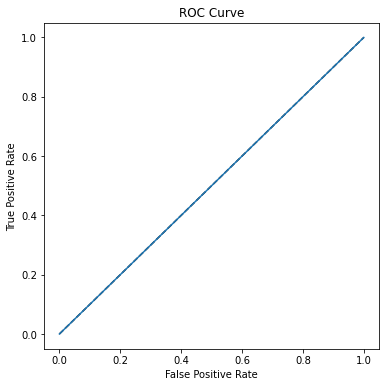

In [11]:
dummy = DummyClassifier(strategy = 'most_frequent')
score(dummy)

In [12]:
# Create a dataframe to keep track of feature importances
importances = pd.DataFrame(index=[X.columns])

### Decision Tree

Text(0.5, 1.0, 'Max Features')

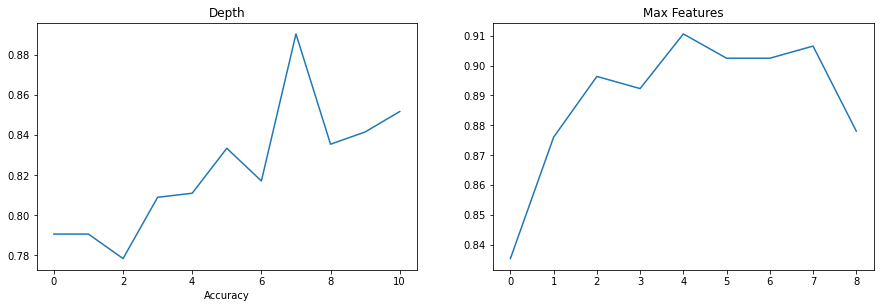

In [13]:
# Because tuning is 'cheap' for a decion tree I will do a quick tune before creating my baseline model for 
# comparison

depth_scores = []
for depth in range(1,12):
    # Initialize and train our tree.
    decision_tree = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=1,
        max_depth=depth,
        random_state = 4123 # keep the random state the same to best see how my changes impact the model
    )
    decision_tree.fit(X_train, y_train)
    depth_scores.append(decision_tree.score(X_test, y_test))
    
    
features_scores = [] 
for feature in range(1,10):
    # Initialize and train our tree.
    decision_tree = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=feature,
        max_depth=9,
        random_state = 4123 # keep the random state the same to best see how my changes impact the model
    )
    decision_tree.fit(X_train, y_train)
    features_scores.append(decision_tree.score(X_test, y_test))
    
plt.figure(figsize=(15,10))    
plt.subplot(2,2,1)
plt.plot(depth_scores)
plt.title('Depth')
plt.xlabel('Accuracy')

plt.subplot(2,2,2)
plt.plot(features_scores)
plt.title('Max Features')
#print('Train score results: ', decision_tree.score(X_train, y_train), '\n', '=' * 22)
#print ('Test score results: ', decision_tree.score(X_test, y_test))

In [14]:
# Train and score a decision tree model
    
    decision_tree = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=2,
        max_depth=9,
        random_state = 4123 # keep the random state the same to best see how my changes impact the model
    )
    
score(decision_tree)

IndentationError: unexpected indent (<ipython-input-14-4e23b18b2f32>, line 3)

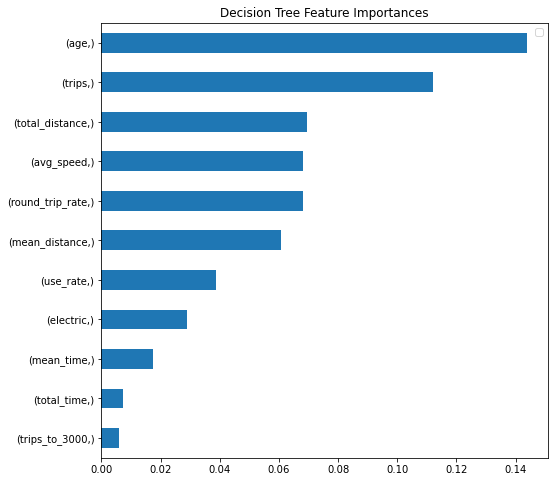

In [44]:
# Get the feature importance
out =decision_tree.tree_.compute_feature_importances(normalize=False)

decision_tree_importances = pd.DataFrame(data=out
                                         , index=[X.columns], columns=['decision_tree'])

importances = importances.join(decision_tree_importances)

fig, ax = plt.subplots(figsize=(8,8))
decision_tree_importances.sort_values(by='decision_tree').plot(kind='barh', ax=ax)
plt.title('Decision Tree Feature Importances')
plt.legend([])

### Random Forest

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    374                 12
True Retired                         19                 87 

Accuracy Score: 0.9369918699186992
Recall Score: 0.8207547169811321
Precision Score: 0.8787878787878788
F-1 Score: 0.8487804878048781
Area under the ROC curve: 0.9795678951999217


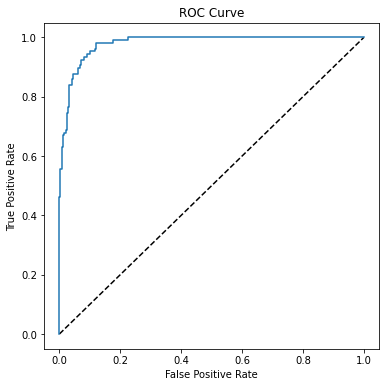

In [15]:
# Train and score a Random Forest model
rfc = ensemble.RandomForestClassifier(
    n_estimators=1000
    , max_features=4
    ,max_depth=10)

score(rfc)

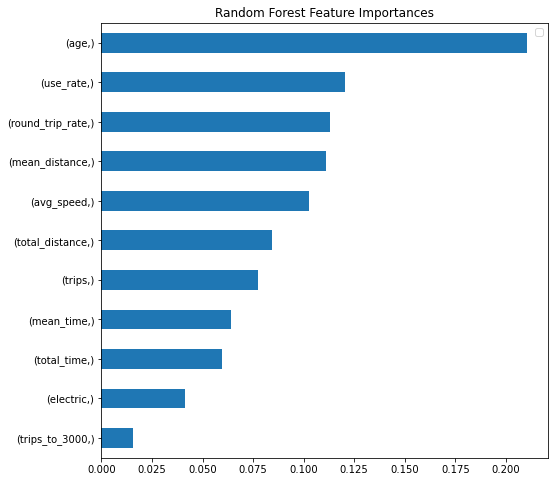

In [16]:
# Get the F
out = rfc.feature_importances_
random_forest_importances = pd.DataFrame(data=out
                                         , index=[X.columns], columns=['random_forest'])

importances = importances.join(random_forest_importances)


fig, ax = plt.subplots(figsize=(8,8))
random_forest_importances.sort_values(by='random_forest').plot(kind='barh', ax=ax)
plt.title('Random Forest Feature Importances')
plt.legend([])

### KNN

In [17]:
# KNN also requires some tuning to achieve even a reasonable baseline and is still fairly 'cheap'

# Here I will loop through some hyperparamater values, comparing their performance for a weighted and 
# unweighted model

train_scores=[]
test_scores=[]
for val in np.arange(1,30):
    knn = neighbors.KNeighborsClassifier(n_neighbors=val)
    knn.fit(X_train, y_train)
    
    train_score = knn.score(X_train, y_train)
    train_scores.append(train_score)
    
    test_score= knn.score(X_test, y_test)
    test_scores.append(test_score)


In [18]:
weighted_train_scores=[]
weighted_test_scores=[]
for val in np.arange(1,30):
    knn = neighbors.KNeighborsClassifier(n_neighbors=val, weights='distance')
    knn.fit(X_train, y_train)
    
    train_score = knn.score(X_train, y_train)
    weighted_train_scores.append(train_score)
    
    test_score= knn.score(X_test, y_test)
    weighted_test_scores.append(test_score)


Text(0.5, 1.0, 'With Weighting')

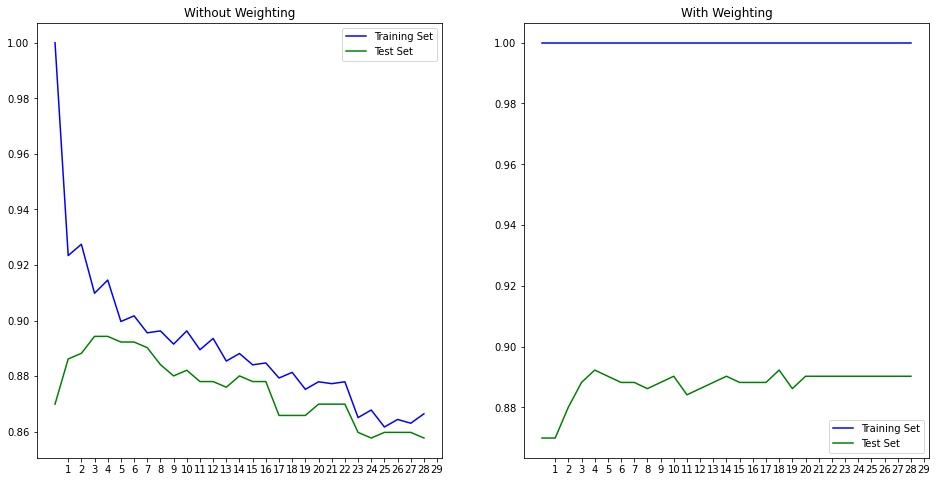

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(train_scores, color='blue', label='Training Set')
plt.plot(test_scores, color='green', label='Test Set')
plt.xticks(np.arange(1,30))
plt.legend()
plt.title('Without Weighting')


plt.subplot(1,2,2)
plt.plot(weighted_train_scores, color='blue', label='Training Set')
plt.plot(weighted_test_scores, color='green', label='Test Set')
plt.xticks(np.arange(1,30))
plt.legend()
plt.title('With Weighting')


-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    373                 13
True Retired                         46                 60 

Accuracy Score: 0.8800813008130082
Recall Score: 0.5660377358490566
Precision Score: 0.821917808219178
F-1 Score: 0.6703910614525139
Area under the ROC curve: 0.9151065597810147


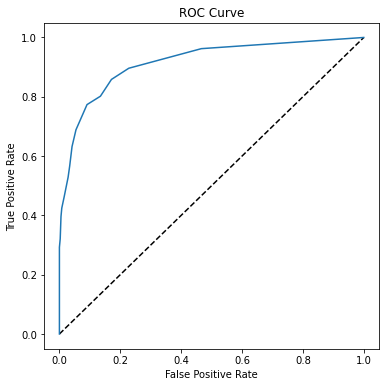

In [20]:
knn = neighbors.KNeighborsClassifier(n_neighbors=15)
score(knn)

In [21]:
# Unfortounately KNN does not offer feature importances or coefficents for us to compare

### Logistic Regression

In [22]:
lrc = LogisticRegression(solver='lbfgs') 

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    386                  0
True Retired                         94                 12 

Accuracy Score: 0.8089430894308943
Recall Score: 0.11320754716981132
Precision Score: 1.0
F-1 Score: 0.2033898305084746
Area under the ROC curve: 0.7475804086420961


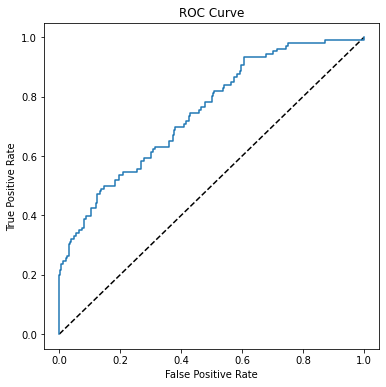

In [23]:
score(lrc)

In [24]:
# As expected Logistic Regression performed quite poorly
# Output the coefficents just for consitancy of evaluation


out = lrc.coef_
pd.DataFrame(data=out.reshape(-1,1), index=[X.columns])

,0
total_time,-0.000068
mean_time,-0.015476
trips,0.000903
total_distance,0.001975
mean_distance,-0.001118
round_trip_rate,-0.000151
trips_to_3000,-0.012247
age,-0.000003
use_rate,0.002937
avg_speed,-0.000647


### AdaBoost

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    375                 11
True Retired                         18                 88 

Accuracy Score: 0.9410569105691057
Recall Score: 0.8301886792452831
Precision Score: 0.8888888888888888
F-1 Score: 0.8585365853658536
Area under the ROC curve: 0.9667367289080067


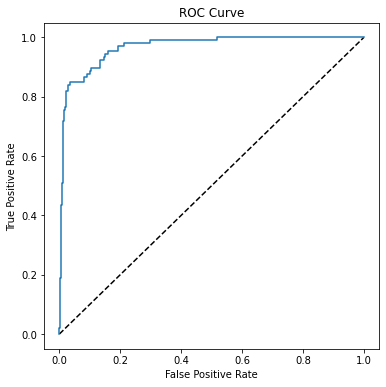

In [27]:
# Fit train and score an AdaBoost model

ada = ensemble.AdaBoostClassifier(
     n_estimators=1000
    , learning_rate=1.0)

score(ada)

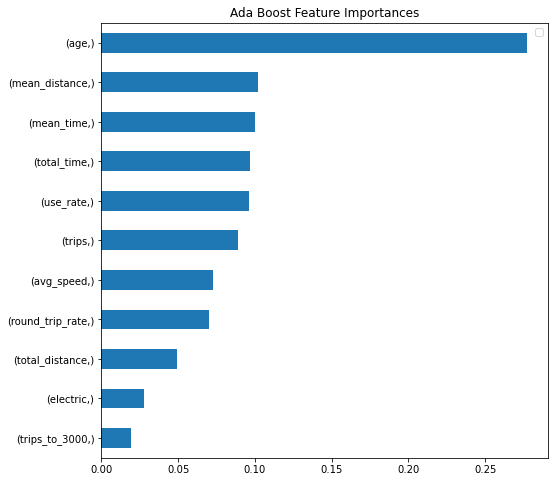

In [28]:
out = ada.feature_importances_

ada_feature_importances = pd.DataFrame(data=out, columns=['AdaBoost'], index=[X.columns])

importances = importances.join(ada_feature_importances)

ada_feature_importances.sort_values(by='AdaBoost')

fig, ax = plt.subplots(figsize=(8,8))
ada_feature_importances.sort_values(by='AdaBoost').plot(kind='barh', ax=ax)
plt.title('Ada Boost Feature Importances')
plt.legend([])

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    375                 11
True Retired                         17                 89 

Accuracy Score: 0.943089430894309
Recall Score: 0.839622641509434
Precision Score: 0.89
F-1 Score: 0.8640776699029127
Area under the ROC curve: 0.9770261022582853


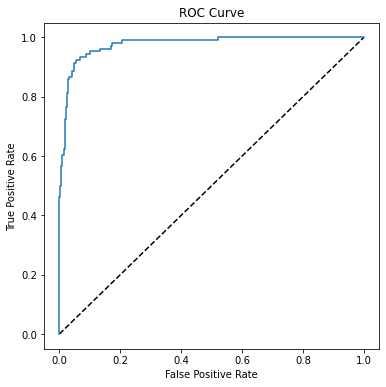

In [29]:
# Fit train and score a XGBoost Model

xgb = XGBClassifier(
    n_estimators=1000
    , learning_rate=1.0)

score(xgb)

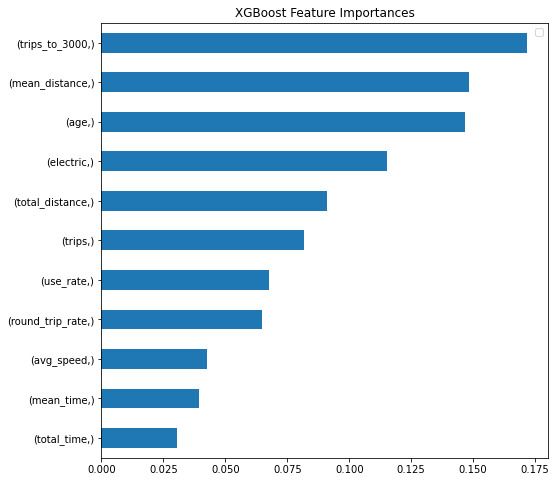

In [30]:
out = xgb.feature_importances_

xgb_feature_importances = pd.DataFrame(data=out, columns =['XGBoost'], index=[X.columns])


importances = importances.join(xgb_feature_importances)

fig, ax = plt.subplots(figsize=(8,8))
xgb_feature_importances.sort_values(by='XGBoost').plot(kind='barh', ax=ax, )
plt.title('XGBoost Feature Importances')
plt.legend([])

### SVC

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    383                  3
True Retired                         68                 38 

Accuracy Score: 0.8556910569105691
Recall Score: 0.3584905660377358
Precision Score: 0.926829268292683
F-1 Score: 0.5170068027210885
Area under the ROC curve: 0.8581728419200313


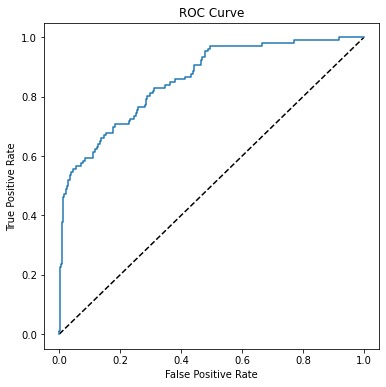

In [31]:
# Scale the data since this is required for proper SVM model performance then train and score an SVC model

scaler = RobustScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.25, random_state=1312)

svc = SVC(kernel='linear', probability=True)
score(svc)

In [32]:
# Produce feature coefficents
out = svc.coef_
pd.DataFrame(data=out.reshape(-1,1), index=[X.columns])

,0
total_time,0.603940
mean_time,-0.079676
trips,-4.117024
total_distance,3.062777
mean_distance,-0.408931
round_trip_rate,-0.251083
trips_to_3000,-0.027140
age,-0.570105
use_rate,0.531045
avg_speed,0.536991


### Evaluating Model Performance so Far

<AxesSubplot:>

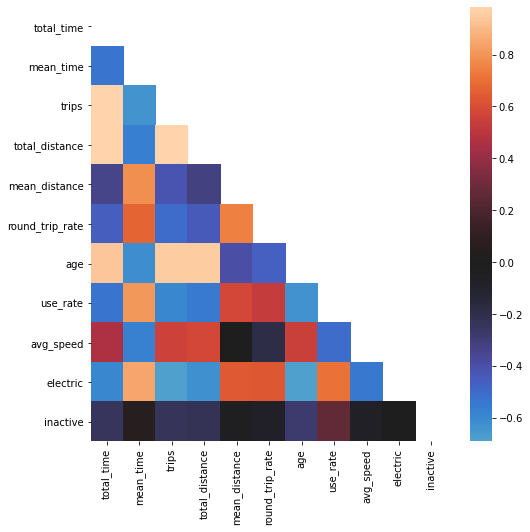

In [33]:
# The Before comparing feature importances consider colinearity.

cols = ['total_time', 'mean_time', 'trips', 'total_distance', 'mean_distance', 'round_trip_rate'
        , 'age', 'use_rate', 'avg_speed', 'electric', 'inactive']
corr_map = df[cols].corr()

mask = np.zeros_like(corr_map, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(corr_map, center=0, mask=mask)

In [46]:
# sort the importances
importances['sum'] = importances.sum(axis=1)
importances = importances.sort_values(by='sum', ascending=False)
importances.drop('sum', axis=1, inplace=True)

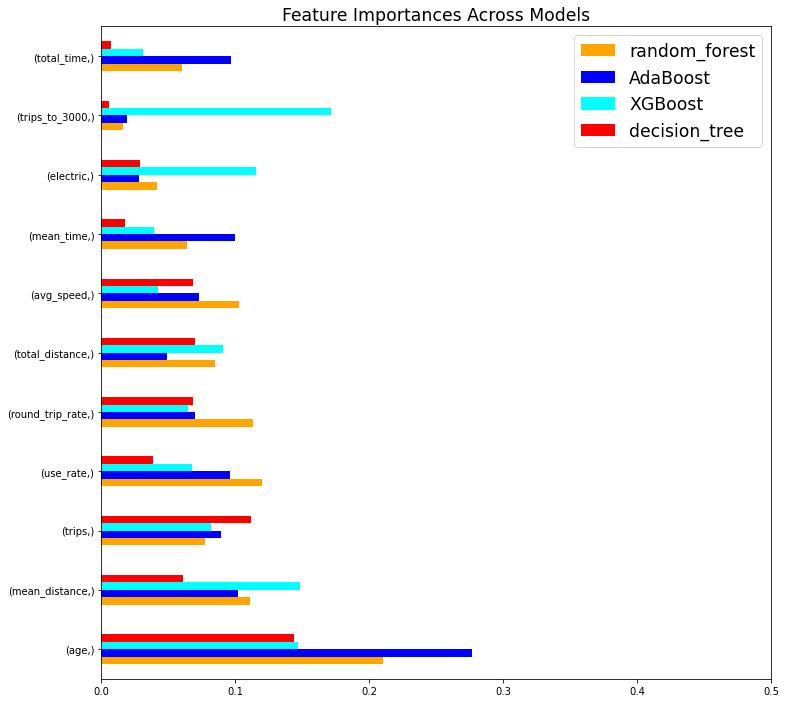

In [47]:
fig, ax = plt.subplots(figsize=(12,12))
importances.plot(kind='barh', stacked=False, color=['orange', 'blue', 'cyan', 'red'], ax=ax)
plt.title('Feature Importances Across Models', size='xx-large')
plt.xlim(0,.5)
plt.legend(fontsize='xx-large')
plt.show()

Note that some of the features are extremely strongly correlated, as discussed in EDA. While decision tree based models are not adversely affected by multicolinearity it can impact the way that we consider feature importance. Because the model can select one of two highly correlated features as important the other will become very unimportant because it contains no new information as compared to the feature that was selected. So these feature importances are not entirely reliable or should be interpreted with that understanding.


XGBoost so far has not only performed best but has the most different feature importance. It takes into account outlier trips much more than any other model. 

In [48]:
# Use cross validation to confirm the three best solvers. AdaBoost, RandomForest, and XGBoost 
# all performed significantly better than the others and similarly to eachother.

solvers = {ada : 'AdaBoost Classifier' ,rfc : 'Random Forest Classifier',  xgb : 'XGBoost Classifier'}

for algo, name in solvers.items():
    scores = cross_val_score(algo, X_train, y_train, cv = 5)
    print('5 fold cross validation score mean for {}:  {}'.format(name, scores.mean()))

5 fold cross validation score mean for AdaBoost Classifier:  0.919322033898305
5 fold cross validation score mean for Random Forest Classifier:  0.9227118644067798
5 fold cross validation score mean for XGBoost Classifier:  0.9342372881355931


## Conclusions and Discussion

The XGBoost Model performed best though similarly to other decision tree based models. Due to lack of linear separability along many of the features, linear models performed poorly as expected. This XGBoost could benefit further from more tuning, and according to the business case be modified for high precision or recall.


This model significantly outperforms a baseline model but can still be improved significantly. In addition this project would benefit from better data, which is likely available internally to the company. Aggregation and some careful assumptions lead to this output. Based upon the success of the model under these challenging circumstances it represents strong proof of concept that this model or one similar to it could produce valuable insights for Inedgo.